In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
from tagger.charbilstmcrf import CharBiLSTMCRF
from etc.customUtil import showGraph, showParallel
from etc import defaultsetting as ds

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = ds.TOKKEN_PAD_IDX
tag_UNK = ds.TOKKEN_UNK_IDX

datasets, engdict, posdict = localdata.load_kor_ner(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

14096
1446
23
13
245
4
245
250
500
4250


In [5]:
def iteration(samples, optimizer):
    x_train, y_train = samples

    optimizer.zero_grad()

    loss = model(engdict, device, x_train, y_train)
    
    loss.backward()
    optimizer.step()

    return loss

In [6]:
def epoch(model, optimizer, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer)
        list_loss.append(loss.item())
    return list_loss

In [7]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        loss = model(engdict, device, x_train, y_train, lossmode=True)
        
        total_loss += loss.item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    num_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        tagged = model(engdict, device, x_train, lossmode=False)
        tagged = torch.tensor(tagged, device=device)
        
        for i in range(y_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
    
    return (cnt_corr_samples / num_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [9]:
def train_losses_scores(model, optimizer, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, dataloader_dev))
        dict_losses['test'].append(evaluate(model, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_crf_ner.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(engdict, device, input_seq, lossmode=False)
#     print(o)
#     __tagged, tagged = torch.max(o, dim=-1)
    return o

In [11]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq])[0])
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
# criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = CharBiLSTMCRF(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch Dev F1 score: 0.0 -> 0.8032
2 epoch Dev F1 score: 0.8032 -> 0.815312
3 epoch Dev F1 score: 0.815312 -> 0.852358
4 epoch Dev F1 score: 0.852358 -> 0.87814
5 epoch Dev F1 score: 0.87814 -> 0.92065
6 epoch Dev F1 score: 0.92065 -> 0.931755
7 epoch Dev F1 score: 0.931755 -> 0.942536
8 epoch Dev F1 score: 0.942536 -> 0.949525
10 epoch Dev F1 score: 0.949525 -> 0.954744
11 epoch Dev F1 score: 0.954744 -> 0.958325
12 epoch Dev F1 score: 0.958325 -> 0.960986
14 epoch Dev F1 score: 0.960986 -> 0.962567
15 epoch Dev F1 score: 0.962567 -> 0.963257
18 epoch Dev F1 score: 0.963257 -> 0.964967
19 epoch Dev F1 score: 0.964967 -> 0.965425
24 epoch Dev F1 score: 0.965425 -> 0.96602
30 epoch Dev F1 score: 0.96602 -> 0.966527
36 epoch Dev F1 score: 0.966527 -> 0.966646
38 epoch Dev F1 score: 0.966646 -> 0.966683
47 epoch Dev F1 score: 0.966683 -> 0.967006
48 epoch Dev F1 score: 0.967006 -> 0.967566
60
	5787.774711847305


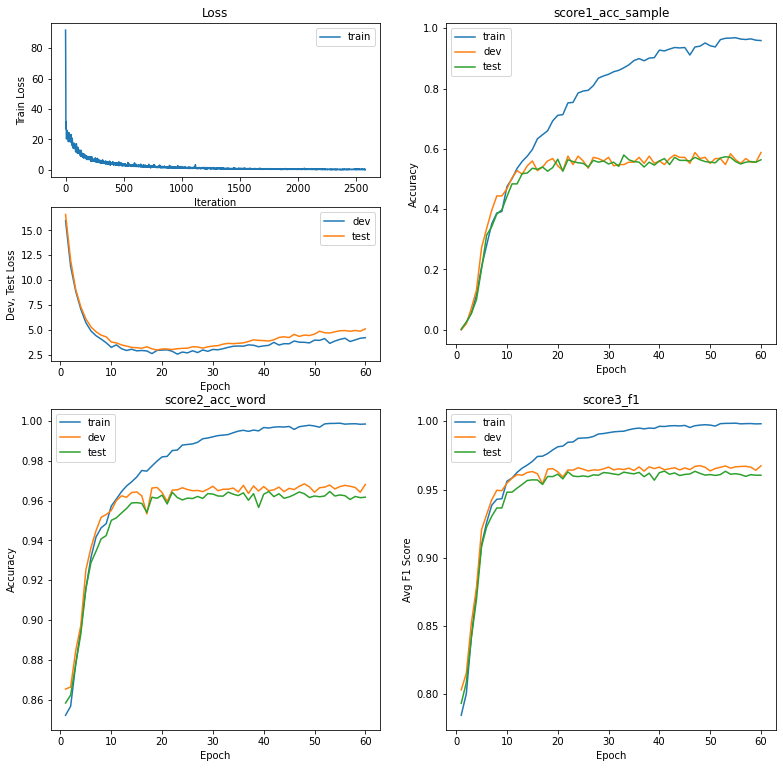

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.78461   0.8032   0.79326
0.80036   0.8153   0.80858
0.84223   0.8524   0.84151
0.87572   0.8781   0.86942
0.90967   0.9206   0.90838
0.92594   0.9318   0.92264
0.93853   0.9425   0.93046
0.9429   0.9495   0.93655
0.94333   0.9492   0.93655
0.95616   0.9547   0.94811
0.95851   0.9583   0.94813
0.96266   0.961   0.9511
0.96576   0.9606   0.95382
0.968   0.9626   0.9567
0.97068   0.9633   0.95717
0.9743   0.9616   0.95706
0.97452   0.954   0.95379
0.97638   0.965   0.95963
0.97908   0.9654   0.95953
0.98141   0.963   0.9613
0.98189   0.9592   0.95787
0.98473   0.9644   0.96299
0.98491   0.9643   0.95997
0.98759   0.966   0.95952
0.98783   0.965   0.96005
0.98804   0.9637   0.95947
0.98895   0.9645   0.96082
0.99076   0.9643   0.96054
0.99112   0.9652   0.96251
0.99174   0.9665   0.96214
0.99234   0.9645   0.96144
0.99265   0.9652   0.96089
0.99282   0.9647   0.9628
0.99389   0.9658   0.96209
0.99467   0.964   0.96154
0.99513   0.9666   0.96263
0.99452   0.9636   0.95948
0.99513   0.9667

In [50]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 42
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
지난                  O       O
1                   O       O
차                   O       O
전                   O       O
에서                  O       O
심판                  O       O
판정                  O       O
에                   O       O
대한                  O       O
불만                  O       O
으로                  O       O
퇴장                  O       O
을                   O       O
당하                  O       O
는                   O       O
등                   O       O
제                   O       O
몫                   O       O
을                   O       O
하                   O       O
지                   O       O
못했                  O       O
던                   O       O
KCC                 B-OG    B-OG
의                   O       O
서장훈                 B-PS    B-PS
은                   O       O
25                  O       O
점                   O       O
6                   O       O
리                   O       O
바운드                 O       

In [18]:
# sen = 'I am your father .'
# # in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

# # sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
# #         4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
# #          116, 4616, 4617,   17]
# # in_sen = torch.tensor(sen2, device=device)

# calc(model, sen)

In [19]:
best_model = torch.load('best_char_bilstm_crf_ner.pt')
s_dev = scores(best_model, datasets['dev'], 100)
s_test = scores(best_model, datasets['test'], 100)
print(s_dev)
print(s_test)

(0.568, 0.9683345780433159, 0.9675662517547607)
(0.564, 0.9633843140209448, 0.9619127511978149)
